# Problemas de grafos

## Grafos coloridos em `NetworkX`

In [12]:
import networkx as nx

Os vértices e as arestas de um grafo em `NetworkX` podem ter atributos. Por exemplo, podemos usar o atributo `color` para definir a cor de cada vértice. Os atributos podem ser definidos de muitas formas, por exemplo, usando a função `set_node_attributes`. O código seguinte começa por gerar o grafo de Petersen, um conhecido grafo com 10 vértices (https://en.wikipedia.org/wiki/Petersen_graph), usando a função `petersen_graph`. Depois define o atributo `color` de todos os vértices com a cor `red`.

In [13]:
petersen = nx.petersen_graph()
nx.set_node_attributes(petersen,'red','color')
print(petersen.nodes.data())

[(0, {'color': 'red'}), (1, {'color': 'red'}), (2, {'color': 'red'}), (3, {'color': 'red'}), (4, {'color': 'red'}), (5, {'color': 'red'}), (6, {'color': 'red'}), (7, {'color': 'red'}), (8, {'color': 'red'}), (9, {'color': 'red'})]


É possível alterar ou acrescentar um atributo a um vértice acedendo ao respectivo dicionário de atributos.

### petersen.nodes[0]['color'] = 'yellow'
print(petersen.nodes.data())

Infelizmente, a função `draw` não tem este atributo em consideração.

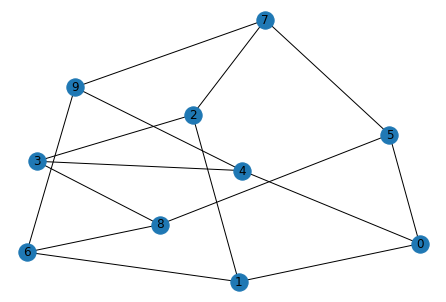

In [14]:
nx.draw(petersen, with_labels = True)

Um dos parâmetros da função `draw` é o `node_color`, que permite definir uma cor para todos os vértices ou passar uma lista com uma cor diferente para cada vértice.

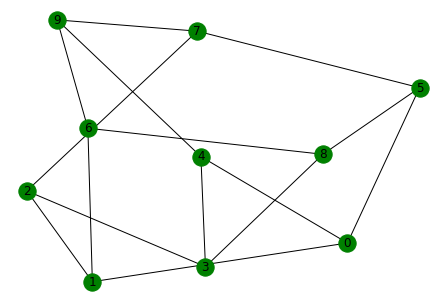

In [15]:
nx.draw(petersen, with_labels = True, node_color = 'green')

### Exercício 1
Defina uma função `draw_with_colors` que, dado um grafo onde os vértices têm o atributo `color` definido, desenhe esse grafo tendo as cores nesse atributo em consideração.

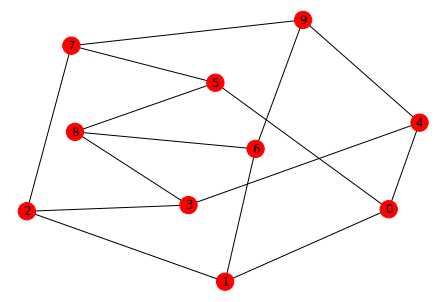

In [16]:
def draw_with_colors(graph):
    nx.draw(graph, with_labels = True, node_color = [graph.nodes[v]['color'] for v in graph])
    
draw_with_colors(petersen)

## O problema da coloração de grafos

O problema da *coloração de grafos* (https://en.wikipedia.org/wiki/Graph_coloring) consiste em descobrir uma atribuição de cores aos vértices, de tal forma que vértices adjacentes não tenham a mesma cor. Temos duas variantes deste problema:
- Problema de decisão: dado um grafo e um número não negativo $k$ determinar se é possível colorir o grafo com no máximo $k$ cores, devolvendo uma coloração válida se tal for possível.
- Problema de optimização: dado um grafo determinar o menor $k$ para o qual isso é possível (o *número cromático* do grafo).

Por exemplo, o grafo de Petersen tem número cromático 3.

### Exercício 2
Defina a função `valid_color` que testa se um grafo tem uma coloração válida.

In [17]:
def valid_color(graph):
    for o in graph:
        for d in graph[o]:
            if graph.nodes[o]['color'] == graph.nodes[d]['color']:
                return False
    return True
assert not valid_color(petersen)

Obviamente, se $k$ igual ao número de vértices do grafo é trivial descobrir uma coloração válida.

### Exercício 3
Implemente a função `trivial_color` que, dado um grafo e um número não negativo $k$, testa se é possível colorir o mesmo de forma trivial usando $k$ cores, atribuindo uma cor diferente a cada vértice. Como cores poderão usar números inteiros positivos.

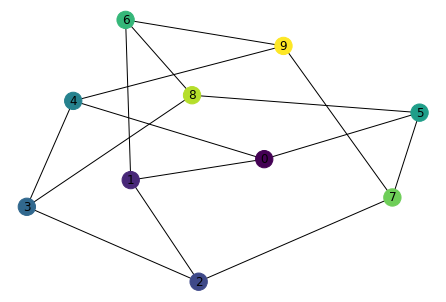

In [18]:
def trivial_color(graph, k):
    if (len(graph)>k):
        return False
    c = 0
    for v in graph:
        graph.nodes[v]['color'] = c
        c = c+1
    return True

assert not trivial_color(petersen, 3)
assert trivial_color(petersen, len(petersen))
draw_with_colors(petersen)

É possível definir uma função que testa se é possível colorir um grafo com $k$ cores usando uma técnica de pesquisa exaustiva.

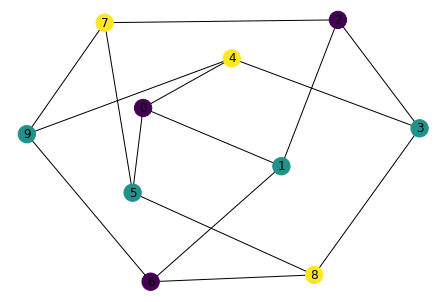

In [19]:
def brute_force_color(graph,k):
    color = {}
    if aux(graph,k,color):
        nx.set_node_attributes(graph,color,'color')
        return True
    else:
        return False

def aux(graph,k,color):
    if len(color) == len(graph): 
        for o in graph:
            for d in graph[o]:
                if color[o] == color[d]:
                    return False
        return True
    v = list(graph.nodes)[len(color)]
    for c in range(k):
        color[v] = c
        if aux(graph,k,color): 
            return True
        color.pop(v)
    return False

assert brute_force_color(petersen,3)
draw_with_colors(petersen)

É possível definir uma função de ordem superior, que dado um grafo e uma função que testa se é possível colorir um grafo com $k$ cores, implementa uma solução para o problema de optimização referido acima (determinar o número cromático) testando sucessivamente todos os valores possíveis para $k$.

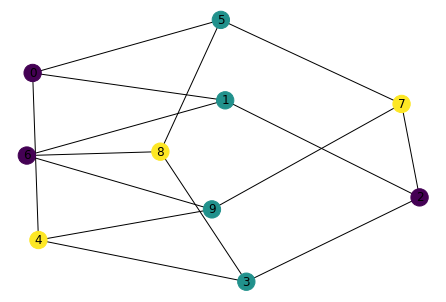

In [20]:
def find_optimal_coloring(graph,testa):
    k = 0
    while not testa(graph,k):
        k += 1
    return k

assert find_optimal_coloring(petersen,brute_force_color) == 3
draw_with_colors(petersen)

## Modelação com Lógica Proposicional

É possível usar lógica proposicional para modelar o problema de colorir um grafo $(V,E)$ com $k$ cores. Para tal, vamos necessitar de $|V| \times k$ variáveis proposicionais, onde a variável $x_{v,c}$ determina se o vértice $v$ tem cor $c$. Para cada aresta $(o,d) \in E$, temos a seguinte restrição que obriga as cores de vértices adjacentes a serem diferentes.
$$
\bigwedge_{c=0}^{k-1} x_{o,c} \rightarrow \neg x_{d,c}
$$
A restrição de que cada vértice $v$ tem exactamente uma cor pode ser implementada por duas restrições mais simples:
1. O vértice $v$ tem pelo menos uma cor.
2. O vértice $v$ não pode ter mais do que uma cor.

### Exercício 4
Indique as fórmulas que modelam estas duas restrições.

Para cada v,
$$
\bigwedge_{c=0}^{k-1} x_{v,c}
$$
Para cada v,
$$
\bigwedge_{c=0}^{k-1}(x_{v,c}\rightarrow \bigwedge_{i=c+1}^{k-1} \neg x_{v,i})
$$

### Exercício 5
Complete a seguinte função que usa lógica proposicional em Z3 para testar se é possível colorir um grafo com $k$ cores. Note que deverá criar um dicionário (de dicionários) `x` para fazer o mapeamento entre o identificador de cada vértice e de cada cor e a respectiva variável booleana do Z3 (concretamente, `x[v][c]` corresponde à variável $x_{v,c}$ na modelação acima).

In [21]:
from z3 import *

def sat_color(graph,k):
    s = Solver()
    dic = {}
    
    for v in graph:
        dic[v] = {}
        for c in range(k):
            dic[v][c] = Bools(str(v) + '_' + str(c))
    
    for o in graph:                   #adjacentes com cores diferentes
        for d in graph[o]:
            for c in range(k):
                s.add(Implies(x[o][c],Not(x[d][c])))
    
    for v in graph:                 #no mínimo uma cor por vértice
        s.add(Or(list(x[v].values())))
    
    for v in graph:
        for c in range(k):
            for i in range(c+1,k):
                s.add(Implies(x[v][c],Not(x[v][i])))
    
    if s.check() == sat:
        m = s.model()
        for v in graph:
            for c in range(k):
                if (m[x[v][c]]):
                    graph.nodes[v]['color'] = c
        return True
    else:
        return False
                  
assert find_optimal_coloring(petersen,sat_color) == 3
draw_with_colors(petersen)

NameError: name 'x' is not defined

Para apreciar a diferença de eficiência entre o algoritmo de pesquisa exaustiva e esta implementação em Z3 vamos testar os dois métodos para colorir um grafo circular com 13 vértices. Para medir o tempo de execução vamos usar a função `timeit` da biblioteca `timeit`, que permite executar várias vezes um comando para depois se calcular o tempo médio. Para documentação sobre esta biblioteca consultar https://docs.python.org/2/library/timeit.html.

In [ ]:
from timeit import timeit

cycle = nx.cycle_graph(13)

timeit(setup="from __main__ import find_optimal_coloring,brute_force_color,cycle", \
       stmt="find_optimal_coloring(cycle,brute_force_color)",number=3)/3

In [ ]:
timeit(setup="from __main__ import find_optimal_coloring,sat_color,cycle",\
       stmt="find_optimal_coloring(cycle,sat_color)",number=3)/3

## Modelação com Aritmética Linear Inteira 

Também é possível usar aritmética linear inteira para implementar o problema de decisão - testar se é possível colorir um grafo $(V,E)$ com $k$ cores (representadas por números entre $0$ e $k-1$). Para tal associamos uma variável inteira $c_v$ a cada vértice $v \in V$ do grafo, cujo valor corresponderá à cor desse vértice. Para cada vértice $v \in V$ temos a seguinte restrição, que restringe a sua cor a um número válido.
$$
0 \le c_v < k
$$
Para cada aresta $(o,d) \in E$, temos a seguinte restrição que obriga as cores de vértices adjacentes a serem diferentes.
$$
c_o \neq c_d
$$

### Exercício 6
Complete a seguinte função que usa aritmérica linear inteira em Z3 para testar se é possível colorir um grafo com $k$ cores.

In [ ]:
def lia_color(graph,k):
    s = Solver()
    c = {}
    
    for v in graph:
        c[v] = Int(str(v))
        s.add(0 <= c[v],c[v]<k)       #cor valida
    
    for o in graph:
        for d in graph[o]:
            s.add(c[o] != c[d])       #adjacente com cores diferentes
    
    if s.check() == sat:
        m = s.model()
        
        for v in graph:
            graph.nodes[v]['color'] = m[c[v]].as_long()
        return True
    else:
        return False
            
assert find_optimal_coloring(petersen,lia_color) == 3
draw_with_colors(petersen)

Para comparar a eficiência com os métodos anteriores, vamos aplicar este método à coloração do grafo circular.

In [ ]:
timeit(setup="from __main__ import find_optimal_coloring,lia_color,cycle",\
       stmt="find_optimal_coloring(cycle,lia_color)",number=3)/3

## Modelação com Programação Inteira

Uma alternativa para modelar este problema com aritmética linear inteira seria usar uma técnica semelhante à modelação com lógica proposicional, ou seja usar $|V| \times k$ variáveis inteiras binárias (com valor entre 0 e 1), onde a variável $x_{v,c}$ determina se o vértice $v$ tem cor $c$.

### Exercício 7

Formalize as restrições necessárias com esta abordagem.

### Exercício 8

Complete a seguinte função que usa esta estratégia alternativa com aritmética linear inteira para testar se é possível colorir um grafo com $k$ cores. Note que pode usar a função `Sum` no Z3 para somar uma lista de expressões inteiras.

In [ ]:
def lia_color_binary(graph,k):
    s = Solver()
    # completar
            
assert find_optimal_coloring(petersen,lia_color_binary) == 3
draw_with_colors(petersen)

Mais uma vez, vamos comparar a eficiência com os métodos anteriores.

In [ ]:
timeit(setup="from __main__ import find_optimal_coloring,lia_color_binary,cycle",\
       stmt="find_optimal_coloring(cycle,lia_color_binary)",number=3)/3

Finalmente, vamos comparar a eficiência dos três métodos implementados no Z3 para um grafo completo com 8 vértices.

In [ ]:
complete = nx.complete_graph(8)

timeit(setup="from __main__ import find_optimal_coloring,sat_color,complete",\
       stmt="find_optimal_coloring(complete,sat_color)",number=3)/3

In [ ]:
timeit(setup="from __main__ import find_optimal_coloring,lia_color,complete",\
       stmt="find_optimal_coloring(complete,lia_color)",number=3)/3

In [ ]:
timeit(setup="from __main__ import find_optimal_coloring,lia_color_binary,complete",\
       stmt="find_optimal_coloring(complete,lia_color_binary)",number=3)/3